# Modeling

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix
from IPython.core.display import display, HTML
from sklearn.multiclass import OneVsRestClassifier
import pickle


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('ignore')

In [10]:
import os
from twilio.rest import Client
import time


In [11]:
with open('../../../../../../Documents/chars.txt', 'r') as file:
    file = file.read().splitlines()
client = Client(file[0], file[1])

def message(body):
    mes = client.messages \
                .create(
                     body=body,
                     from_=file[2],
                     to=file[3])

In [12]:
X =pd.read_csv('../data/interim/explantorydf.csv', index_col=0) #read in features and target(s)
y = pd.read_csv('../data/interim/targetdf.csv', index_col=0)

In [14]:
y_fatal= y['Fatal'] # just the fatal class ( binary 0/1)

In [15]:
#split X and Y Fatal
X_train, X_test, y_train, y_test = train_test_split(X, y_fatal, test_size=0.30, random_state=42)


In [16]:
#checking sizes/shapes of splits
y_test.value_counts(), y_train.value_counts()


(0    608524
 1      8240
 Name: Fatal, dtype: int64,
 0    1420075
 1      19038
 Name: Fatal, dtype: int64)

# Modelling

In [66]:
from sklearn.linear_model import LogisticRegression #import classifier
from sklearn.model_selection import RandomizedSearchCV

# First - Logistic - Just on the Fatal Category

In [21]:
logistic = LogisticRegression(solver='saga', 
                              tol=1e-2, 
                              max_iter=200,
                              random_state=0,
                              n_jobs=1,
                              class_weight='balanced')
distributions = dict(C=np.arange(0,11), penalty=['l2', 'l1', 'elasticnet'])
logclf = RandomizedSearchCV(logistic, distributions, random_state=0)

In [17]:
#fit Model

start = time.time()
#search = logclf.fit(X_train, y_train)
time.time()-start

0.0

In [24]:
#Save model to disk

#with open('../models/logistic.pkl', 'wb') as file: 
#    pickle.dump(search, file)
    


In [25]:
#load model from disk
search = pickle.load(open('../models/logistic.pkl', 'rb'))

In [22]:

y_pred = search.predict(X_test)


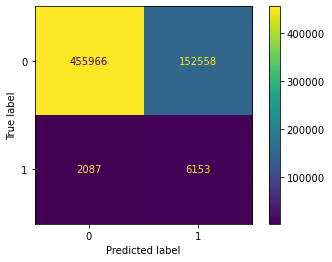

In [23]:
plot_confusion_matrix(search, X_test, y_test, labels = [0, 1])

<AxesSubplot:>

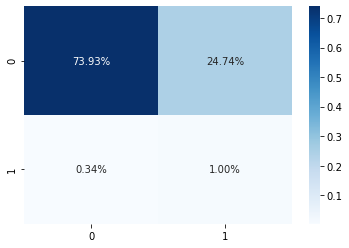

In [26]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [27]:
print(classification_report(y_pred, y_test, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       0.75      1.00      0.86    458053
       Fatal       0.75      0.04      0.07    158711

    accuracy                           0.75    616764
   macro avg       0.75      0.52      0.46    616764
weighted avg       0.75      0.75      0.65    616764



In [29]:
y_pred_proba = search.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
y_pred_proba.shape

(616764, 1)

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 1.0, 'ROC curve for Logistic Regression')

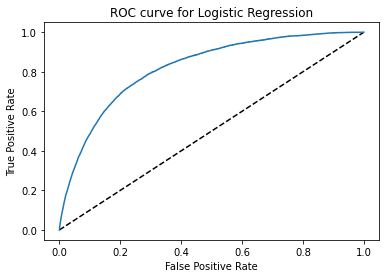

In [33]:
#plot ROC Curve





plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')

# Random Forest Modelling - Fatal vs. Non-Fatal

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
#RandomForestClassifier?

In [69]:
#play with Class weights

clf = RandomForestClassifier()

random_grid ={'max_depth': [2,5,7],
             'min_samples_leaf': [1, 3, 5],
             'min_samples_split': [2, 3, 4, 5],
             'n_estimators': [100],
             'class_weight' : ["balanced"]
             }

rfclf = RandomizedSearchCV(clf, param_distributions = random_grid, n_jobs=1)

In [35]:
#Train Random Forest

#start = time.time()
#rfclf.fit(X_train, y_train)
#message("Train_time="+str(round(((time.time()-start) /3600),3)) + ' hours')

In [36]:
#save Model to disk

#with open('../models/rfmodel.pkl', 'wb') as file:
#    pickle.dump(rfclf, file)

In [37]:
rfclf = pickle.load(open('../models/rfmodel.pkl', 'rb'))

In [38]:
y_pred = rfclf.predict(X_test)

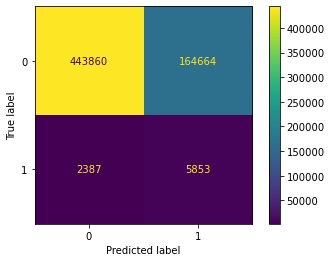

In [39]:
plot_confusion_matrix(rfclf, X_test, y_test, labels = [0, 1])

In [40]:
print(classification_report(y_test, y_pred, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       0.99      0.73      0.84    608524
       Fatal       0.03      0.71      0.07      8240

    accuracy                           0.73    616764
   macro avg       0.51      0.72      0.45    616764
weighted avg       0.98      0.73      0.83    616764



In [41]:
y_pred_proba = rfclf.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
y_pred_proba.shape

(616764, 1)

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 1.0, 'ROC curve for Random Forest Model')

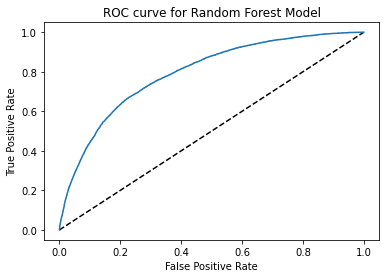

In [43]:
plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Model')

# XGB on Binary response (Fatal vs not Fatal)

In [44]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [45]:
#XGBClassifier?

In [46]:
compute_sample_weight(class_weight='balanced', y=y_train)

array([0.50670317, 0.50670317, 0.50670317, ..., 0.50670317, 0.50670317,
       0.50670317])

In [47]:
xgbclf = XGBClassifier()
param_grid = {'max_depth': [1, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100],
        'scale_pos_weight' : [(y_train==0).sum()/ (y_train==1).sum()]}

In [49]:
#Manual computer Class Weight/Ratio

(y_train==0).sum()/ (y_train==1).sum()

74.59160626116189

In [123]:
rdmxgb = RandomizedSearchCV(xgbclf, param_distributions = param_grid, n_jobs=1)

In [50]:
#Fit RandomSearch XGB Classifier


#start = time.time()
#rdmxgb.fit(X_train, y_train)
#message('Train_time='+str(round(((time.time()-start) /3600),3)) + ' hours')

In [51]:
#Save Classifer to disk

#with open('../models/xgbmodel.pkl', 'wb') as file:
#    pickle.dump(rdmxgb, file)

In [52]:
rdmxgb = pickle.load(open('../models/xgbmodel.pkl', 'rb'))

In [53]:
y_pred = rdmxgb.predict(X_test)

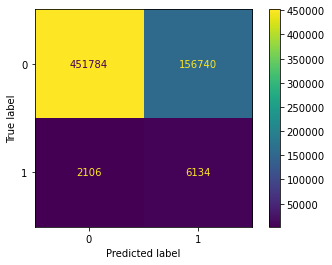

In [54]:
plot_confusion_matrix(rdmxgb, X_test, y_test, labels = [0, 1])

In [56]:
#verifying results
confusion_matrix(y_test, y_pred)

array([[451784, 156740],
       [  2106,   6134]], dtype=int64)

In [58]:
# Total Fatalities in test set
(y_test==1).sum()

8240

In [59]:
y_pred_proba = rdmxgb.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 1.0, 'ROC curve XGBoost Binary Model')

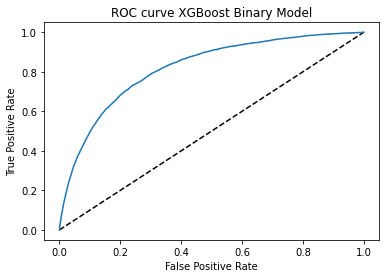

In [61]:
plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve XGBoost Binary Model')

# MultiClass Logistic Modelling



In [64]:
#Sklearn Logistic Regression Requires target be one dimensional

onedimy = y[y==1].stack().reset_index().drop(0,1).set_index('level_0')


X_train, X_test, y_train, y_test = train_test_split(X,onedimy, test_size=0.30, random_state=42)
y_train.head()

,level_1
level_0,
395386,Slight
1820254,Slight
1712893,Slight
78646,Slight
211029,Slight


In [67]:
#Creating a RandomSearchCV for Logistic Regression, Multiclass

logmulti = LogisticRegression(solver='saga', 
                              tol=1e-2, 
                              max_iter=200,
                              random_state=1,
                              n_jobs=1,
                              class_weight='balanced',
                              multi_class='auto')
distributions = dict(C=np.arange(0,11), penalty=['l2','elasticnet'])
rdmlogmulti = RandomizedSearchCV(logmulti, distributions, random_state=0)

In [71]:
#Fit Model and Save to disk


#rdmlogmulti.fit(X_train, y_train)
#with open('../models/rdmlogmulti.pkl', 'wb') as file:
#     pickle.dump(rdmlogmulti, file)


In [78]:
#save model to disk

with open('../models/rdmlogmulti.pkl', 'wb') as file:
    pickle.dump(rdmlogmulti, file)

In [79]:
rdmlogmulti = pickle.load(open('../models/rdmlogmulti.pkl', 'rb'))

In [80]:
y_pred = rdmlogmulti.predict(X_test)

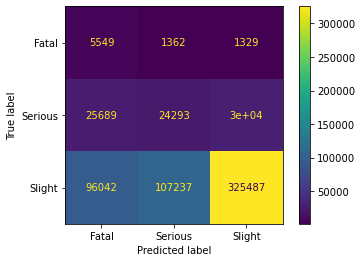

In [81]:
plot_confusion_matrix(rdmlogmulti, X_test, y_test)

In [83]:
rdmlogmulti.best_score_

0.5765676509197727

# Logsitic One VS Rest

In [85]:
#instaniate Randomizedsearch for Logisitic Model One vs Rest

ovr=OneVsRestClassifier(LogisticRegression(solver='saga', 
                     tol=1e-2, 
                     max_iter=200,
                     random_state=1,
                     n_jobs=1,
                     class_weight='balanced',
                     multi_class='auto'))

distributions = dict(estimator__penalty=['l2','elasticnet'],
                     estimator__C=np.arange(1,11)
                    )

OVRrdm = RandomizedSearchCV(ovr, distributions, random_state=0)

In [86]:

#OVRrdm.fit(X_train, y_train)
#with open('../models/OVRrdm.pkl', 'wb') as file:
#    pickle.dump(OVRrdm, file)


In [87]:
OVRrdm = pickle.load(open('../models/OVRrdm.pkl', 'rb'))

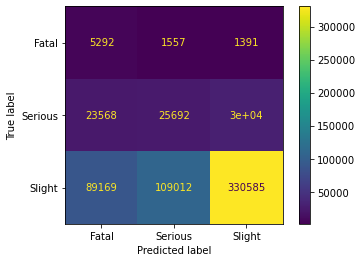

In [88]:
plot_confusion_matrix(OVRrdm, X_test, y_test)